# FB Prophet XGBoost based time series prediction of deaths due to COVID19 in India

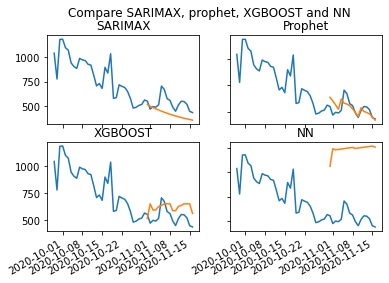

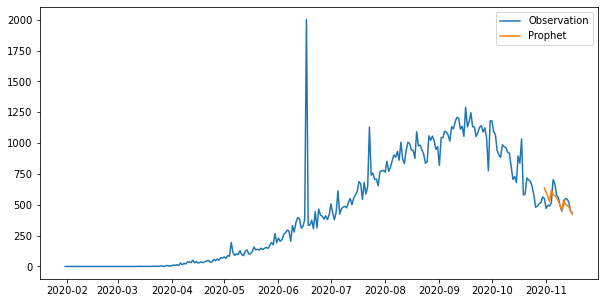
#     Prophet prediction with MAE 52

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from keras.models import Sequential
from keras.layers import Dense

from keras.optimizers import Adam

warnings.filterwarnings('ignore')


In [ ]:
data = pd.read_csv("../input/covid19-in-india/covid_19_india.csv")
data.head(5)

In [ ]:
data.tail(5)

In [ ]:
#Understand the data
data = pd.DataFrame(data)
data.shape
data.columns
len(data.ConfirmedIndianNational)
len(data.Deaths)
len(data.Cured)
len(data.Date)
data.info()
data.describe()
data['ConfirmedIndianNational'].describe()

In [ ]:
#If needed we can also replace the name of column
data = data.rename(columns = {"State/UnionTerritory":"State",
                              "ConfirmedIndianNational":"Confirmed_Indian",
                              "ConfirmedForeignNational":"Confirmed_Foreginer",
                              "Cured":"Recovered"})
data.columns

In [ ]:
#Drop the SNo or column
#ab = data.ix[:,1:]  Another method for droppping column
df = data.drop(['Sno','Time','Confirmed_Indian', 'Confirmed_Foreginer'], axis = 1)
df.columns
df['Date'] = pd.to_datetime(df['Date'], dayfirst = True)
df['Date'] = pd.to_datetime(df['Date'])
#df['Confirmed_Total'] = df['Confirmed_Indian']+df['Confirmed_Foreginer']
df.columns

In [ ]:
df.columns

In [ ]:
TS_df = df.drop(['Recovered','Confirmed'], axis = 1)

In [ ]:
TS_df.columns

In [ ]:
TS_df[150:160]

In [ ]:
State_df=df.sort_values(by=['State', 'Date'])

In [ ]:
State_df.head()

In [ ]:
State_ts = State_df.drop(['Recovered', 'Confirmed'], axis = 1)
State_ts.tail()

In [ ]:
States = State_df.State.unique()
States

In [ ]:
for i in States:
    print(i)
    State_ts.loc[State_ts['State'] == i]

# Lets work on time series predictions

In [ ]:
ts_df=df.groupby('Date')['Deaths'].sum()

In [ ]:
ts_df

In [ ]:
ts_df = pd.DataFrame(ts_df)
ts_df.head(5)

In [ ]:
ts_df.describe()

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(ts_df)
plt.savefig('Cummulative daily deaths', bbox_inches='tight', transparent=False)

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(ts_df.diff())
plt.savefig('Daily deaths', bbox_inches='tight', transparent=False)

In [ ]:
ts_diff = ts_df.diff()

In [ ]:
ts_diff.head(5)

In [ ]:
ts_diff.tail(5)

In [ ]:
#ts_diff=ts_diff.reset_index()

In [ ]:
ts_diff.columns

In [ ]:
#dates = list(ts_diff.Date[:])

In [ ]:
#from datetime import datetime
#dates1=datetime.fromtimestamp(dates[0])

In [ ]:
#dates[0]

In [ ]:
ts_diff.head(5)

In [ ]:
ts_diff.tail()

We need to remove the first data point here, which will be a None value

In [ ]:
ts_diff = ts_diff.loc['2020-01-31':'2020-11-16']

In [ ]:
#ts_diff = ts_diff[1:291]
ts_diff.head(5)

Forcasting using SARIMAX, or Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

In [ ]:
ts_diff

In [ ]:
#from pandas import Timestamp
start_date = '2020-10-31'

train = ts_diff.loc[ts_diff.index < pd.to_datetime(start_date)]
test = ts_diff.loc[ts_diff.index >= pd.to_datetime(start_date)]

In [ ]:
train.index

In [ ]:
#train['Date']= pd.to_datetime(train['Date'])
#test['Date']= pd.to_datetime(test['Date'])

In [ ]:
test.index

In [ ]:
model = SARIMAX(train, order=(2, 1, 3))

In [ ]:
results = model.fit(disp=True)

In [ ]:
from pandas import Timestamp
sarimax_prediction = results.predict(
    start=start_date, end=Timestamp('2020-11-16'), dynamic=False)
plt.figure(figsize=(10, 5))
l1, = plt.plot(ts_diff, label='Observation')
l2, = plt.plot(sarimax_prediction, label='ARIMA')
plt.legend(handles=[l1, l2])
plt.savefig('SARIMAX prediction', bbox_inches='tight', transparent=False)

In [ ]:
print('SARIMAX MAE = ', mean_absolute_error(sarimax_prediction, test))

# Forcasting using Facebook's Prophet model

Prophet expects the data frame to have 2 columns, unlike SARIMAX.

In [ ]:
train

In [ ]:
train=train.reset_index()
train

Prophet needs the column names as ds and y for dates and response(deaths here)

In [ ]:
trainProphet=train.rename(columns = {'Date':'ds','Deaths':'y'})

In [ ]:
testProphet=test.rename(columns = {'Date':'ds','Deaths':'y'})

In [ ]:
testProphet

In [ ]:
trainProphet

In [ ]:
m = Prophet()
m.fit(trainProphet)

In [ ]:
ts_diff.shape[0]

In [ ]:
prediction_size=ts_diff.shape[0]-trainProphet.shape[0]
prediction_size

In [ ]:
future = m.make_future_dataframe(periods=prediction_size,freq = "D", include_history = True)
prophet_prediction = m.predict(future)

Now let us calculate the mean absolute error for our predictions

In [ ]:
start_date

In [ ]:
prophet_prediction = prophet_prediction.set_index('ds')
prophet_future = prophet_prediction.yhat.loc[prophet_prediction.index >= start_date]

In [ ]:
print('Prophet MAE = ', mean_absolute_error(prophet_future, testProphet))

In [ ]:
plt.figure(figsize=(10, 5))
l1, = plt.plot(ts_diff, label='Observation')
l2, = plt.plot(prophet_future, label='Prophet')
plt.legend(handles=[l1, l2])
plt.savefig('Prophet predictions',
           bbox_inches='tight', transparent=False)

# Hyperparameter tuning of Prophet

HyperParameter Tuning using ParameterGrid

In [ ]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'seasonality_prior_scale':[10,15,20,25],
               #'daily_seasonality':(True,False),
               #'yearly_seasonality':(True,False),
               #'weekly_seasonality':(True,False),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

In [ ]:
mae = mean_absolute_error(testProphet['y'],prophet_future)
print("MAE",round(mae,4))

In [ ]:
import random

In [ ]:
''''#strt='2019-12-31'
#end='2020-02-26'
num=0
model_parameters = pd.DataFrame(columns = ['MAE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         #weekly_seasonality=p['weekly_seasonality'],
                         #daily_seasonality = p['daily_seasonality'],
                         #yearly_seasonality = p['yearly_seasonality']
                        )
    train_model.fit(trainProphet)
    train_forecast = train_model.make_future_dataframe(periods=17, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = testProphet['y']
    MAE = mean_absolute_error(Actual,abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAE)------------------------------------',MAE)
    print('Model',num)
    num=num+1
    model_parameters = model_parameters.append({'MAE':MAE,'Parameters':p},ignore_index=True)'''

{'changepoint_prior_scale': 0.2, 'daily_seasonality': True, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'weekly_seasonality': True, 'yearly_seasonality': False}
Mean Absolute Percentage Error(MAE)------------------------------------ 52.43015684378985
{'changepoint_prior_scale': 0.2, 'daily_seasonality': True, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20, 'weekly_seasonality': True, 'yearly_seasonality': False}
Mean Absolute Percentage Error(MAE)------------------------------------ 52.43015684378985

In [ ]:
parameters = model_parameters.sort_values(by=['MAE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

In [ ]:
parameters['Parameters'][0]

'changepoint_prior_scale': 0.2,
 'daily_seasonality': True,
 'holidays_prior_scale': 0.4,
 'n_changepoints': 100,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 20,
 'weekly_seasonality': True,
 'yearly_seasonality': False

In [ ]:
opt_prophet = Prophet(changepoint_prior_scale = 0.2,
                      daily_seasonality = True,
                      holidays_prior_scale = 0.4,
                      n_changepoints = 100,
                      seasonality_mode = 'multiplicative',
                      seasonality_prior_scale = 20,
                      weekly_seasonality = True, 
                      yearly_seasonality = False)
opt_prophet.fit(trainProphet)

In [ ]:
prediction_size=ts_diff.shape[0]-trainProphet.shape[0]
prediction_size

In [ ]:
future = opt_prophet.make_future_dataframe(periods=prediction_size,freq = "D", include_history = True)
prophet_prediction = opt_prophet.predict(future)

In [ ]:
start_date

In [ ]:
prophet_prediction = prophet_prediction.set_index('ds')
prophet_future = prophet_prediction.yhat.loc[prophet_prediction.index >= start_date]

In [ ]:
print('Prophet MAE = ', mean_absolute_error(prophet_future, testProphet))

In [ ]:
plt.figure(figsize=(10, 5))
l1, = plt.plot(ts_diff, label='Observation')
l2, = plt.plot(prophet_future, label='Prophet')
plt.legend(handles=[l1, l2])
plt.savefig('Prophet predictions',
           bbox_inches='tight', transparent=False)

# Preparing the dataset for XGBOOST and NN

In [ ]:
ts_diff

In [ ]:
def featurize(t):
    X = pd.DataFrame()
    
    X['day'] = t.index.day
    X['month'] = t.index.month
    X['quarter'] = t.index.quarter
    X['dayofweek'] = t.index.dayofweek
    X['dayofyear'] = t.index.dayofyear
    X['weekofyear'] = t.index.weekofyear
    y = t.Deaths
    return X, y

In [ ]:
featurize(ts_diff)[0].head()

# Create training and test datasets by splitting the dataset, and perform data normalization.

In [ ]:
X_train, y_train = featurize(
    ts_diff.loc[ts_diff.index < pd.to_datetime(start_date)])
X_test, y_test = featurize(
    ts_diff.loc[ts_diff.index >= pd.to_datetime(start_date)])

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

In [ ]:
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

# Train the XGBOOST and NN models

In [ ]:
XGBOOST_model = XGBRegressor(n_estimators=10)

In [ ]:
XGBOOST_model.fit(scaled_train, y_train,
                 eval_set=[(scaled_train, y_train), (scaled_test, y_test)],
                 verbose=True)
XGBOOST_prediction = XGBOOST_model.predict(scaled_test)

In [ ]:
print('XGBOOST MAE = ', mean_absolute_error(XGBOOST_prediction, y_test))

Creation and training of the feedforward neural network model.

In [ ]:
NN_model = Sequential()
NN_model.add(Dense(20, input_shape=(scaled_train.shape[1],)))
NN_model.add(Dense(10))
NN_model.add(Dense(1))
NN_model.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.01))
NN_model.fit(scaled_train, y_train, validation_data=(
    scaled_test, y_test), epochs=220, verbose=1)
NN_prediction = NN_model.predict(scaled_test)

In [ ]:
print('XGBOOST MAE = ', mean_absolute_error(XGBOOST_prediction, y_test))
print('Prophet MAE = ', mean_absolute_error(prophet_future, testProphet))
print('SARIMAX MAE = ', mean_absolute_error(sarimax_prediction, test))
print('NN MAE = ', mean_absolute_error(NN_prediction, test))

In [ ]:

XGBOOST_df = pd.DataFrame({'y': XGBOOST_prediction.tolist()})
XGBOOST_df.index = y_test.index

NN_df = pd.DataFrame(NN_prediction)
NN_df.index = y_test.index
plt.figure(figsize=(20, 20))
fig, axs = plt.subplots(2, 2)
fig.suptitle('Compare SARIMAX, prophet, XGBOOST and NN')
axs[0, 0].plot(ts_diff.tail(50))
axs[0, 0].plot(sarimax_prediction.tail(50))
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(ts_diff.tail(50))
axs[0, 1].plot(prophet_future.tail(50))
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(ts_diff.tail(50))
axs[1, 0].plot(XGBOOST_df.tail(50))
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(ts_diff.tail(50))
axs[1, 1].plot(NN_df.tail(50))
axs[1, 1].set_title("NN")

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

plt.savefig('Comparison',
            bbox_inches='tight', transparent=False)

In [ ]:
train['Deaths'] = train['Deaths'].astype(int)

In [ ]:
train['Deaths']

Now let's talk about SARIMAX. There are three hyperparameters that go into the order tuple: p, q and d. Here we've used p=2, q=1 and d=3.

In [ ]:
ts_df1['Date']=ts_df.index

In [ ]:
#ts_df=ts_df.drop(ts_df.index,axis=0)

In [ ]:
ts_df1=pd.DataFrame(ts_df,columns=['Deaths'])

In [ ]:
ts_df1

In [ ]:
ts_df1.reset_index()

In [ ]:
area_pop = pd.read_excel("../input/india-area-population/AreaPopulation.xlsx",
                         sheet_name='Data')

In [ ]:
area_pop.head(10)

In [ ]:
area_pop.columns

In [ ]:
area_pop1=area_pop.drop([area_pop.index[0]])

In [ ]:
area_pop1

In [ ]:
area_pop1=pd.DataFrame(area_pop1)
area_pop1.columns[0]

In [ ]:
area_pop1.sort_values(by=area_pop1.columns[0])